# Impacts of Amazon deforestation scenarios on surface-atmosphere Hg exchange.
### IMPORT

In [45]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 3 2022
Mapping terrestrial-atmosphere exchange in simulations for paper
@author: arifeinberg
"""

'\nCreated on Mon Oct 3 2022\nMapping terrestrial-atmosphere exchange in simulations for paper\n@author: arifeinberg\n'

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import scipy.io as sio
import datetime
import xarray as xr
from helper_functions import ds_sel_yr, annual_avg, open_Hg
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as colors

## load area and masks


In [47]:
# Load grid cell area for unit conversion of model
fn_gbox = '/mnt/data-summer-user/analysis_scripts/misc_Data/GEOSChem_2x25_gboxarea.nc'
ds_gbox = xr.open_dataset(fn_gbox)
gbox_GC = ds_gbox.cell_area #m2

# Load Amazon mask
fn_Am_mask = '/mnt/data-summer-user/analysis_scripts/misc_Data/Amazon_basin_mask_2x25.nc'
ds_Am_mask = xr.open_dataset(fn_Am_mask)
Am_mask = ds_Am_mask.MASK #unitless

## Load emissions fluxes

In [48]:
sim = ['0311','0312','0313', '0315']
sim_name = ['HIST',  '2050–BAU', '2050–GOV', 'SAV']

# initialize matrices
balance = []
dep_Hg0_all = []
# run loop
for i in range(len(sim)):
    sim_i = sim[i]
    fn_emis = '/mnt/data-summer-user/src/data_feinberg/Feinberg23_deforest_Hg/GC_data/run'+sim_i+'/GEOSChem.MercuryEmis.2015_m.nc4'
    ds_emis = xr.open_dataset(fn_emis)
    lon = ds_emis.lon
    lat = ds_emis.lat
    soil_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0soil', 2015) 
    land_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0land', 2015) 
    geogen_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0geogenic', 2015) 
    bb_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0biomass', 2015) 
    ant0_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0anthro', 2015) 
    ant2_emis_yr = ds_sel_yr(ds_emis, 'EmisHg2HgPanthro', 2015) 
    ocean_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0ocean', 2015) 
    
    
    # Convert model data from kg/s to kg/yr for annual average   
    s_in_yr = 365.2425 * 24 * 3600 # s in one year
    
    unit_conv = s_in_yr
        
    soil_emis = annual_avg(soil_emis_yr) * unit_conv # kg/yr
    land_emis = annual_avg(land_emis_yr) * unit_conv # kg/yr
    geogen_emis = annual_avg(geogen_emis_yr) * unit_conv # kg/yr
    bb_emis = annual_avg(bb_emis_yr) * unit_conv # kg/yr
    ant0_emis = annual_avg(ant0_emis_yr) * unit_conv # kg/yr
    ant2_emis = annual_avg(ant2_emis_yr) * unit_conv # kg/yr
    ocean_emis = annual_avg(ocean_emis_yr) * unit_conv # kg/yr
    
    # Load deposition fluxes
    # dry dep
    fn_dd = '/mnt/data-summer-user/src/data_feinberg/Feinberg23_deforest_Hg/GC_data/run'+sim_i+'/GEOSChem.DryDep.2015_m.nc4'
    ds_dd = xr.open_dataset(fn_dd)
    
    dd_Hg0_yr = ds_sel_yr(ds_dd, 'DryDep_Hg0', 2015) 
    dd_Hg2_yr = ds_sel_yr(ds_dd, 'DryDep_Hg2', 2015) 
    dd_HgP_yr = ds_sel_yr(ds_dd, 'DryDep_HgP', 2015) 
    
    # Convert model data from molec/cm2/s to kg/yr for annual average   
    s_in_yr = 365.2425 * 24 * 3600 # s in one year
    g_kg = 1e-3 # g in kg
    cm2_m2 = 1e4 # cm^2 in m^2
    MW_Hg = 200.59 # g mol^-1
    avo = 6.02e23 # avogadro number molec mol^-1
    
    unit_conv = MW_Hg / avo * g_kg * cm2_m2 * s_in_yr * gbox_GC # constant to convert units
    
    dd_Hg0 = annual_avg(dd_Hg0_yr) * unit_conv # kg/yr
    dd_Hg2 = annual_avg(dd_Hg2_yr) * unit_conv # kg/yr
    dd_HgP = annual_avg(dd_HgP_yr) * unit_conv # kg/yr
    
    # wet dep
    fn_dd = '/mnt/data-summer-user/src/data_feinberg/Feinberg23_deforest_Hg/GC_data/run'+sim_i+'/GEOSChem.WetLossTotal.2015_m.nc4'
    ds_dd = xr.open_dataset(fn_dd)
    
    wd_Hg_yr = ds_sel_yr(ds_dd, 'WetLossTot_Hg', 2015) 
    
    # Convert model data from kg/s to kg/yr for annual average   
    s_in_yr = 365.2425 * 24 * 3600 # s in one year
    
    unit_conv = s_in_yr
    
    wd_Hg = annual_avg(wd_Hg_yr) * unit_conv # kg/yr

    # sea salt loss 
    fn_ss = '/mnt/data-summer-user/src/data_feinberg/Feinberg23_deforest_Hg/GC_data/run'+sim_i+'/GEOSChem.MercuryChem.2015_m.nc4'
    ds_ss = xr.open_dataset(fn_ss)
    
    ss_Hg2_yr = ds_sel_yr(ds_ss, 'LossHg2bySeaSalt_v', 2015) 
    
    # Convert model data from kg/s to kg/yr for annual average   
    s_in_yr = 365.2425 * 24 * 3600 # s in one year
    
    unit_conv = s_in_yr
    
    ss_Hg2 = annual_avg(ss_Hg2_yr) * unit_conv # kg/yr
    
    # totals emiss, dep, balance
    emiss_total = soil_emis + land_emis + geogen_emis + bb_emis + ant0_emis + ant2_emis + ocean_emis # kg/yr
    dep_total = dd_Hg0 + dd_Hg2 + dd_HgP + wd_Hg + ss_Hg2 # kg/yr
    balance.append((emiss_total - dep_total)) # kg/yr
    dep_Hg0_all.append((dd_Hg0)) # kg/yr

## Shift pcolormesh lat and lon

In [49]:
# extend longitude by 2
lon_extend = np.zeros(lon.size+2)
# fill in internal values
lon_extend[1:-1] = lon # fill up with original values
# fill in extra endpoints
lon_extend[0] = lon[0]-np.diff(lon)[0]
lon_extend[-1] = lon[-1]+np.diff(lon)[-1]
# calculate the midpoints
lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

# extend latitude by 2
lat_extend = np.zeros(lat.size+2)
# fill in internal values
lat_extend[1:-1] = lat
# fill in extra endpoints
lat_extend[0] = lat[0]-np.diff(lat)[0]
lat_extend[-1] = lat[-1]+np.diff(lat)[-1]
# calculate the midpoints
lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))

## Plot map plots

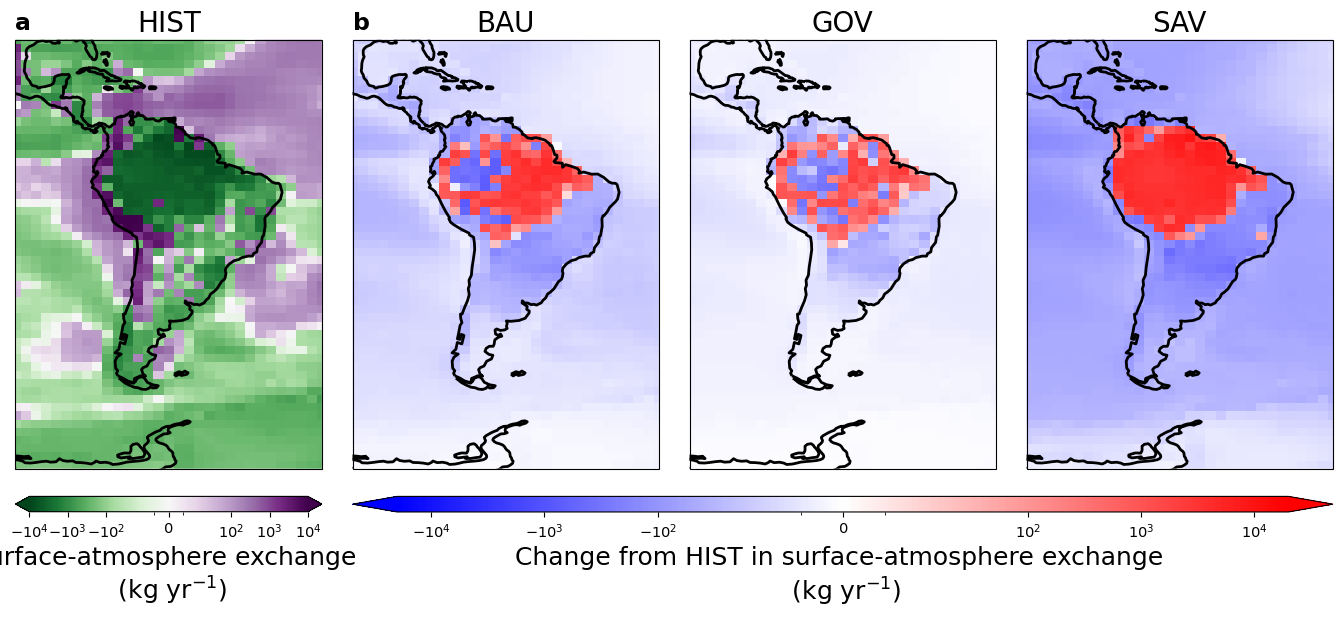

In [50]:
lat_min = -75
lat_max = 30
lon_min = -100
lon_max = -25
titles = ['HIST', 'BAU', 'GOV', 'SAV']
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.cm.bwr

f, axes = plt.subplots(1, 4, figsize=[17,12],subplot_kw=dict(projection=ccrs.PlateCarree()),
                              gridspec_kw=dict(hspace=0., wspace=0.1))
axes = axes.flatten()

h = axes[0].pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, 
                       balance[0], cmap='PRGn_r',
                       norm=colors.SymLogNorm(linthresh=30, linscale=1,
                                          vmin=-1e4, vmax=1e4),
                       rasterized = True)
axes[0].set_xlim([lon_min, lon_max])
axes[0].set_ylim([lat_min, lat_max])
axes[0].set_title(titles[0],  fontsize=20)
axes[0].coastlines(linewidth=2)
axes[0].text(0.0, 1.04, 'a', fontweight='bold',fontsize=17,
             horizontalalignment='left', verticalalignment='center',
             transform=axes[0].transAxes)
cbar = plt.colorbar(h, extend='both',ax=axes[0],ticks=[-10000, -1000, -100,0, 100, 1000, 10000 ],
                    orientation='horizontal', pad=0.03)
cbar.set_label('Surface-atmosphere exchange \n (kg yr$^{-1}$)', fontsize = 18)
cbar.ax.tick_params(labelsize=10.5) 


for i in range(1,len(sim)):
    h = axes[i].pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints,
                           balance[i]-balance[0], cmap =cmap,
                           norm=colors.SymLogNorm(linthresh=30, linscale=1,
                                              vmin=-2e4, vmax=2e4),
                           rasterized = True)
    #cbar.tick_params(labelsize=14)
    axes[i].set_xlim([lon_min, lon_max])
    axes[i].set_ylim([lat_min, lat_max])
    axes[i].set_title(titles[i], fontsize=20)
    
    axes[i].coastlines(linewidth=2)
    
axes[1].text(0., 1.04, 'b', fontweight='bold',fontsize=17,
             horizontalalignment='left', verticalalignment='center',
             transform=axes[1].transAxes)

#f.subplots_adjust(bottom=0.4)
aspect = 20
pad_fraction = 0.5

cbar = f.colorbar(h, extend='both',orientation='horizontal',
                  ticks=[-10000, -1000, -100,0, 100, 1000, 10000 ],
                  ax=axes[1:].ravel().tolist(), pad=0.03,aspect=63)
cbar.set_label('Change from HIST in surface-atmosphere exchange \n (kg yr$^{-1}$)', fontsize = 18)
cbar.ax.tick_params(labelsize=10.5) 
f.savefig('/home/jovyan/colomb_ige-m2-internship-2025_MERCAMAZON-project/figures/Paper_terr_ex_maps_v2.pdf', bbox_inches='tight')

## Calculate land sink difference

In [52]:
# Load land mask
balance_BAU = balance[0]-balance[1]
balance_GOV = balance[0]-balance[2]
balance_SAV = balance[0]-balance[3]

fn_land = '/mnt/data-summer-user/src/data_feinberg/Feinberg23_deforest_Hg/analysis_scripts/misc_Data/landmask_geos2x25.nc'
ds_l = xr.open_dataset(fn_land)
mask_l = ds_l.sea
print("Diff over land")
print((balance_SAV * mask_l).sum()/1000.)

Diff over land
<xarray.DataArray ()> Size: 8B
array(342.87809341)


## Plot percent diff for BAU deposition

In [53]:
depHg0_BAU_pct = (dep_Hg0_all[1] - dep_Hg0_all[0])/dep_Hg0_all[0]*100
print(depHg0_BAU_pct.max())
depHg0_GOV_pct = (dep_Hg0_all[2] - dep_Hg0_all[0])/dep_Hg0_all[0]*100
print(depHg0_GOV_pct.max())

<xarray.DataArray ()> Size: 8B
array(21.43130248)
<xarray.DataArray ()> Size: 8B
array(9.87564541)
